### Importing Libraries

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models, datasets, transforms
import matplotlib.pyplot as plt
import pickle
import urllib.request

import numpy as np
from PIL import Image
import os
%matplotlib inline

### Importing Model

In [17]:
# import resnet152 model from pytorch hub
model = torch.hub.load('pytorch/vision:v0.10.0', 'resnet152', 
                       weights='ResNet152_Weights.IMAGENET1K_V2')
# Set model to evaluation mode
model.eval()

Using cache found in /Users/sb/.cache/torch/hub/pytorch_vision_v0.10.0


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [18]:
# Obtaining classes from the imagenet dataset to map the output of the model to human readable classes
classes = pickle.load(urllib.request.urlopen('https://gist.githubusercontent.com/yrevar/6135f1bd8dcf2e0cc683/raw/d133d61a09d7e5a3b36b8c111a8dd5c4b5d560ee/imagenet1000_clsid_to_human.pkl'))

### Normalizing Images


In [19]:
# Normalize the image to the same mean and standard deviation as the training data. Also resize the image to 224x224 as required by the model.
def preprocess_image(dir_path, display=False):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    
    dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            normalize])) #normalize the tensor
    if display:
        dataset = datasets.ImageFolder(dir_path, transforms.Compose([
            transforms.Resize(256), 
            transforms.CenterCrop(224), # resize the image to 224x224
            transforms.ToTensor(), # convert numpy.array to tensor
            ]))
    return (dataset)

### Importing and displaying Images

In [20]:
# set the directory path to the dataset
dir_path = "dataset" 
dataset = preprocess_image(dir_path)
display_dataset = preprocess_image(dir_path, display=True)
files= os.listdir(os.path.join(dir_path,'images'))

Top 3-classes: [(250, 'Siberian husky', 8.082574), (249, 'malamute, malemute, Alaskan malamute', 7.075353), (248, 'Eskimo dog, husky', 5.742148)]


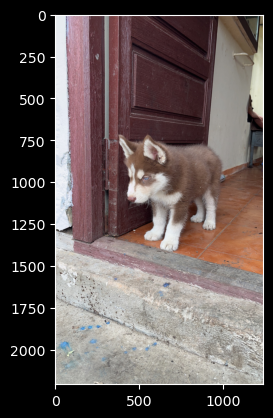

In [21]:
# show first image from the dataset, along with the top 3 classes predicted by the model
input_image = Image.open(dataset.imgs[0][0]).convert('RGB')
plt.imshow(input_image)

output = model(dataset[0][0].view(1, 3, 224, 224))
values, indices = torch.topk(output, 3)
classes_score=list(zip(indices[0].numpy(), [classes[x] for x in indices[0].numpy()],values[0].detach().numpy()))
print("Top 3-classes:", classes_score)

### GradCAM implementation

In [22]:
class GradCAM:
    """
    Class to generate GradCAM images. This class takes a model and a layer name as input and generates GradCAM images. This class also has a __call__ method which allows the class to be called like a function. 
    """
    def __init__(self,model,layer_name):
        # initialize the model and the layer name, and register hooks to the model
        self.model=model
        self.forward_features=None
        self.backward_gradients=None
        
        self.cam_layer=getattr(self.model,layer_name)
        
        self.cam_layer[-1].register_forward_hook(self.forward_features_hook)
        self.cam_layer[-1].register_full_backward_hook(self.backward_gradients_hook)
    
    def forward_features_hook(self,module,input,output):
        # save forward pass output
        self.forward_features=output

    def backward_gradients_hook(self,module,grad_input,grad_output):
        # save backward pass gradients
        self.backward_gradients=grad_output[0]
    
    def __call__(self, x):
        # calling class like a function
        return self.model(x)
    
    def generata_grad_cam(self):
        # weights by averaging the gradients
        layer_weights=F.adaptive_avg_pool2d(self.backward_gradients,(1,1))
        # Combining forward features with weights
        grad_cam=torch.mul(self.forward_features,layer_weights).sum(dim=1,keepdim=True)
        grad_cam=F.relu(grad_cam)

        # resizing GradCAM to the input image size for visualization
        grad_cam_image=F.interpolate(grad_cam, size=(224,224), mode='bilinear', align_corners=False)
        # normalizing GradCAM to be between 0 and 1 for visualization
        grad_cam_image=grad_cam_image-torch.min(grad_cam_image)
        grad_cam_image=grad_cam_image/torch.max(grad_cam_image)
        
        return grad_cam_image

In [23]:
def get_grad_cam(index,layer_name='layer4'):
    # generating GradCAM results for the layer specified
    grad_cam = GradCAM(model,layer_name)
    output = grad_cam(dataset[index][0].view(1, 3, 224, 224))
    values, indices = torch.topk(output, 3)
    
    # performe forward pass and backpropagation to get the gradients and generate GradCAM images
    grad_cams = []
    for i in range(3):        
        one_arr = torch.zeros_like(output)
        one_arr[0][indices[0][i]] = 1
        
        output.backward(gradient=one_arr, retain_graph=True)
        cam = grad_cam.generata_grad_cam()
        grad_cams.append(cam)
        
    return grad_cams, values, indices

In [24]:
def display_grad_cam(cams, index, values=0, indices=0,layer_name='layer4'):
    # visualizing original image with overlayed GradCAM results
    image=display_dataset[index][0]
    image_pil = transforms.ToPILImage()(image.squeeze()).convert("RGB")
    # convert the tensor to numpy image
    grad_cams_numpy = [cam.squeeze().detach().numpy()  for cam in cams]
    
    _, ax = plt.subplots(1, 4, figsize=(20, 8))
    ax[0].imshow(image_pil)
    ax[0].set_title(f'Original Image:')
    
    # Display the original image with overlayed GradCAM results
    for index, cam_numpy in enumerate(grad_cams_numpy, start=1):
        ax[index].imshow(image_pil)
        ax[index].imshow(cam_numpy, alpha=0.5, cmap='jet') 
        class_name=classes[indices[0].numpy()[index-1]].replace(',','\n')
        class_score=values[0].detach().numpy()[index-1]
        ax[index].set_title(f'Class :{class_name} \n Score : {class_score:.2f}')
    plt.show()

### Displaying results

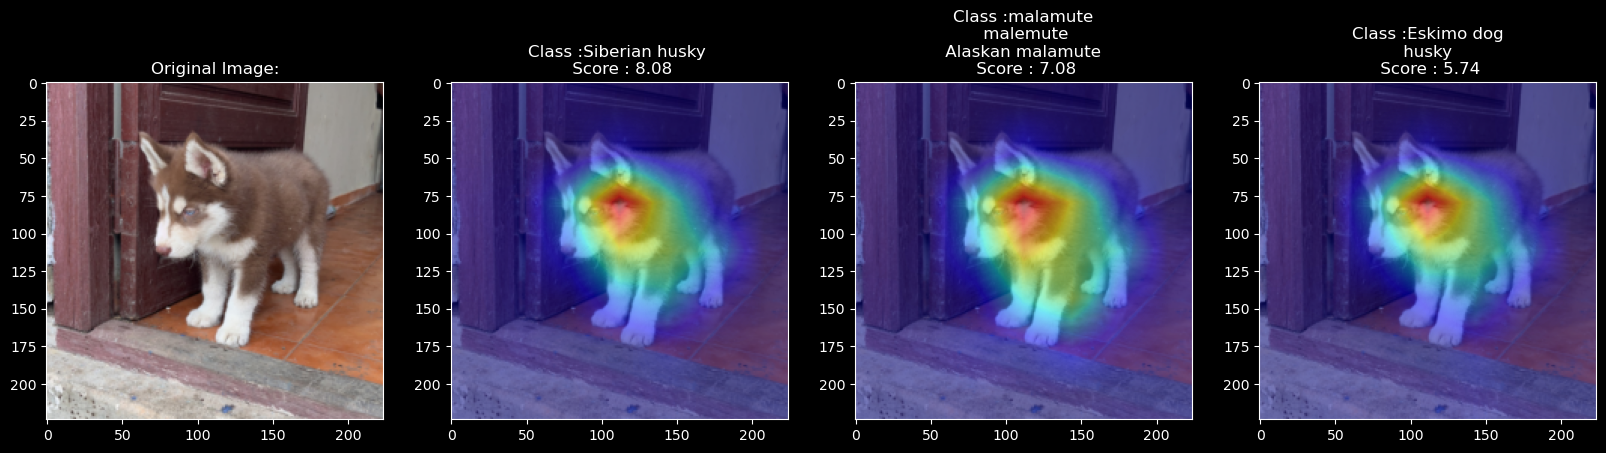

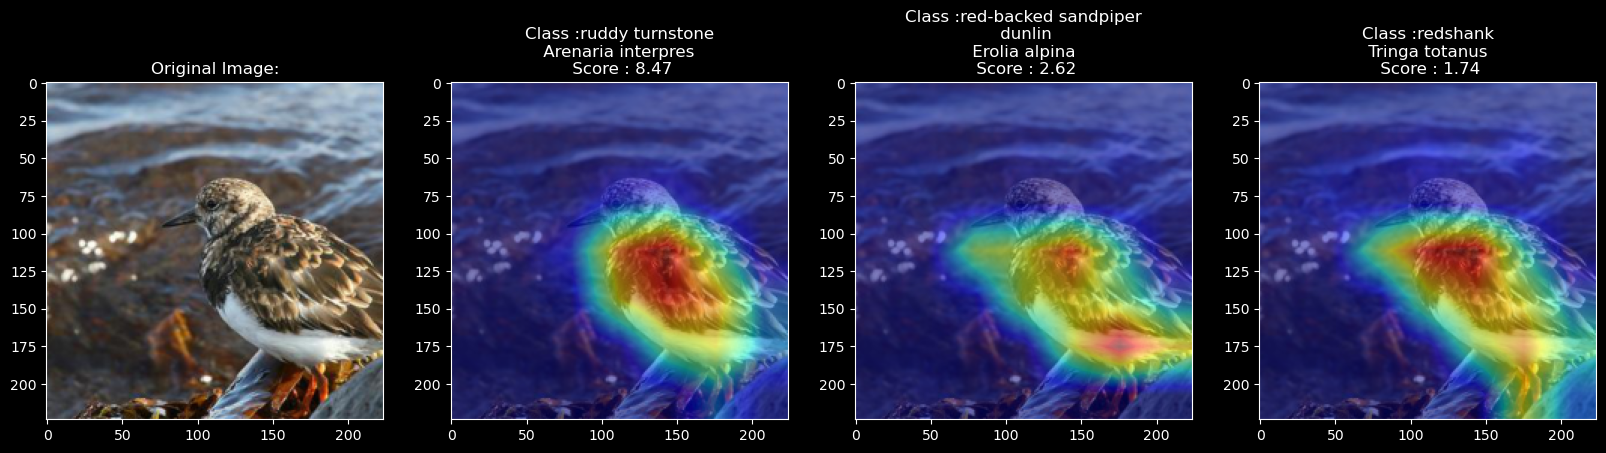

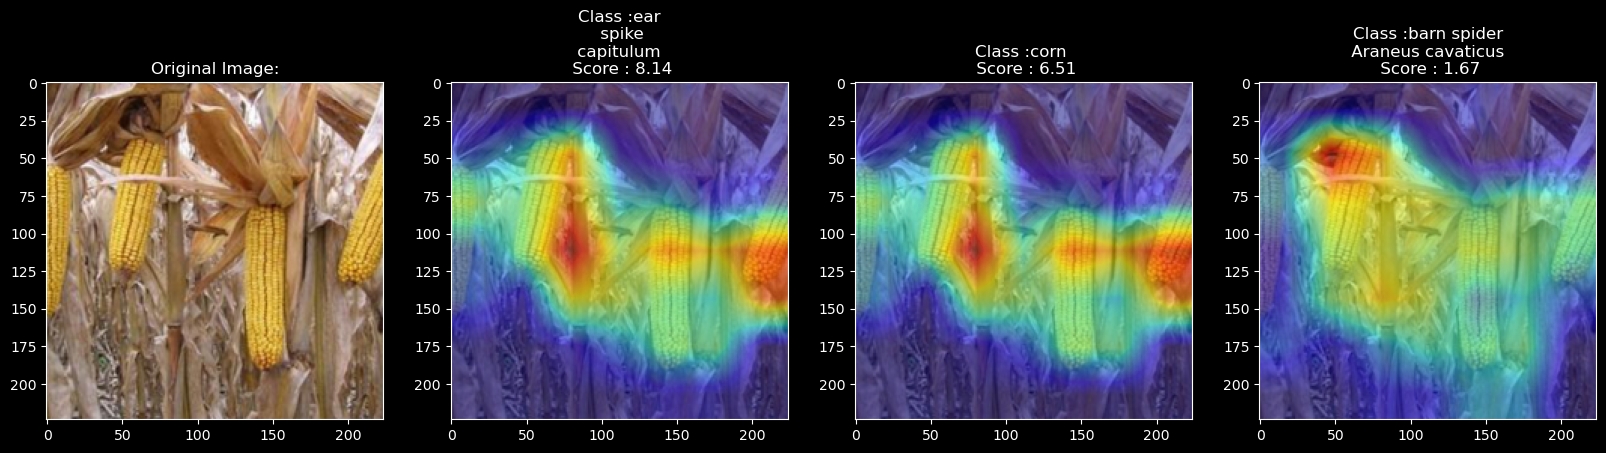

In [25]:
layer_name = 'layer4'
for i in range(len(files)):
    cam,values,indices=get_grad_cam(i,layer_name=layer_name)
    display_grad_cam(cam,i,values,indices,layer_name=layer_name)